## 🏗️ Structural Data Overload
The analysis results for the columns of a timber-concrete hybrid construction are provided within the commit below.

#### 🏃 Step 01 - Receiving commit in a condensed fashion

In [ ]:
# Import required libraries
from specklepy.api.client import SpeckleClient
from specklepy.core.api import operations
from specklepy.transports.server import ServerTransport

# Define global variables 
HOST = "https://app.speckle.systems/"
AUTHENTICATION_TOKEN = ""
STREAM_ID = ""
BRANCH_NAME = ""

# Setting up SpeckleClient and authenticating
client = SpeckleClient(host=HOST)
client.authenticate_with_token(token=AUTHENTICATION_TOKEN)

# Receving commit
transport = ServerTransport(STREAM_ID, client)
branch = client.branch.get(stream_id=STREAM_ID, name=BRANCH_NAME)
model_data = operations.receive(branch.commits.items[0].referencedObject, transport)

#### 🔍 Step 02 - Where To Start?
Maybe the question is, where on earth do I even start??
* `model_data` is at the root of our commit, below visualized as the `structural/analytical` object
* `AnalysisResults` is "nested" as a property of each element within `elements` which in turn is within `@Model`. So, we should be able to access it using dot notation
* A safe function to retrieve the attribute is Python's `gettattr()` function, which allows us to do some sort of "error-handling" 
* First step would be to retrieve the `@Model` object
* Second step would be to retrieve the `elements` array. Once we have the array, we can look to filter out the information we actually need

![alt text](<Structural Data Laundary - Where to start-1.png>)

In [ ]:
# Using the above explanation, we can very easily obtain our results object
model_object = getattr(model_data, "@Model", None)

# If we found the @Model, we can carry on
if model_object:
    elements = getattr(model_object, "elements", None)

# If we found the elements, we can carry on
if elements:
    print("Success! We have elements, now we can proceed with filtering.")
    assert len(elements) == 1235 # The size of the array (from the screenshot) indicates, that elements should contain 1235 objects. NOTE: It is usually not a good idea to hard-code these numbers as we have variability from version to version 

####  ⏳ Step 03 - Get Columns Only
So, we have an array of **ALL** objects. But, we want to have just columns. How do we go about this?
* Each `element` within `elements` has a property called `type`. When looking at the viewer, this property has values such as "0" which doesn't mean much to us.
* However, this integer represents a key-value pair which, when deserialized has more information available to us.
* How do I know this? Use the function `vars()` which will printout all attributes of an object together with their value. e.g. `print(vars(elements[0]))`
* Note the value for `type`

In [ ]:
# When you're a little stuck and what to see "what an object has", you can intterogate using either vars(obj) or dir(obj). Both are native Python functions
attributes_of_first_object = vars(elements[0])
for key, value in attributes_of_first_object.items():
    print(f"{key}\t:\t{value}")

In [ ]:
# We want to use type for filtering, but watchout for the datatype!
print(f"Accessing type simply with dot notation might not be as excepted as its not a string. Type = {type(elements[0].type)}")
print(f"But by accessing the name property of the enum, we are good to go! Type = {type(elements[0].type.name)}")

In [ ]:
# When working with large datasets, keep performance in mind. Use for loops sparingly. List comprehension is in these instances better
columns = [element for element in elements if hasattr(element, "type") and "Column" in element.type.name]
assert len(columns) == 372

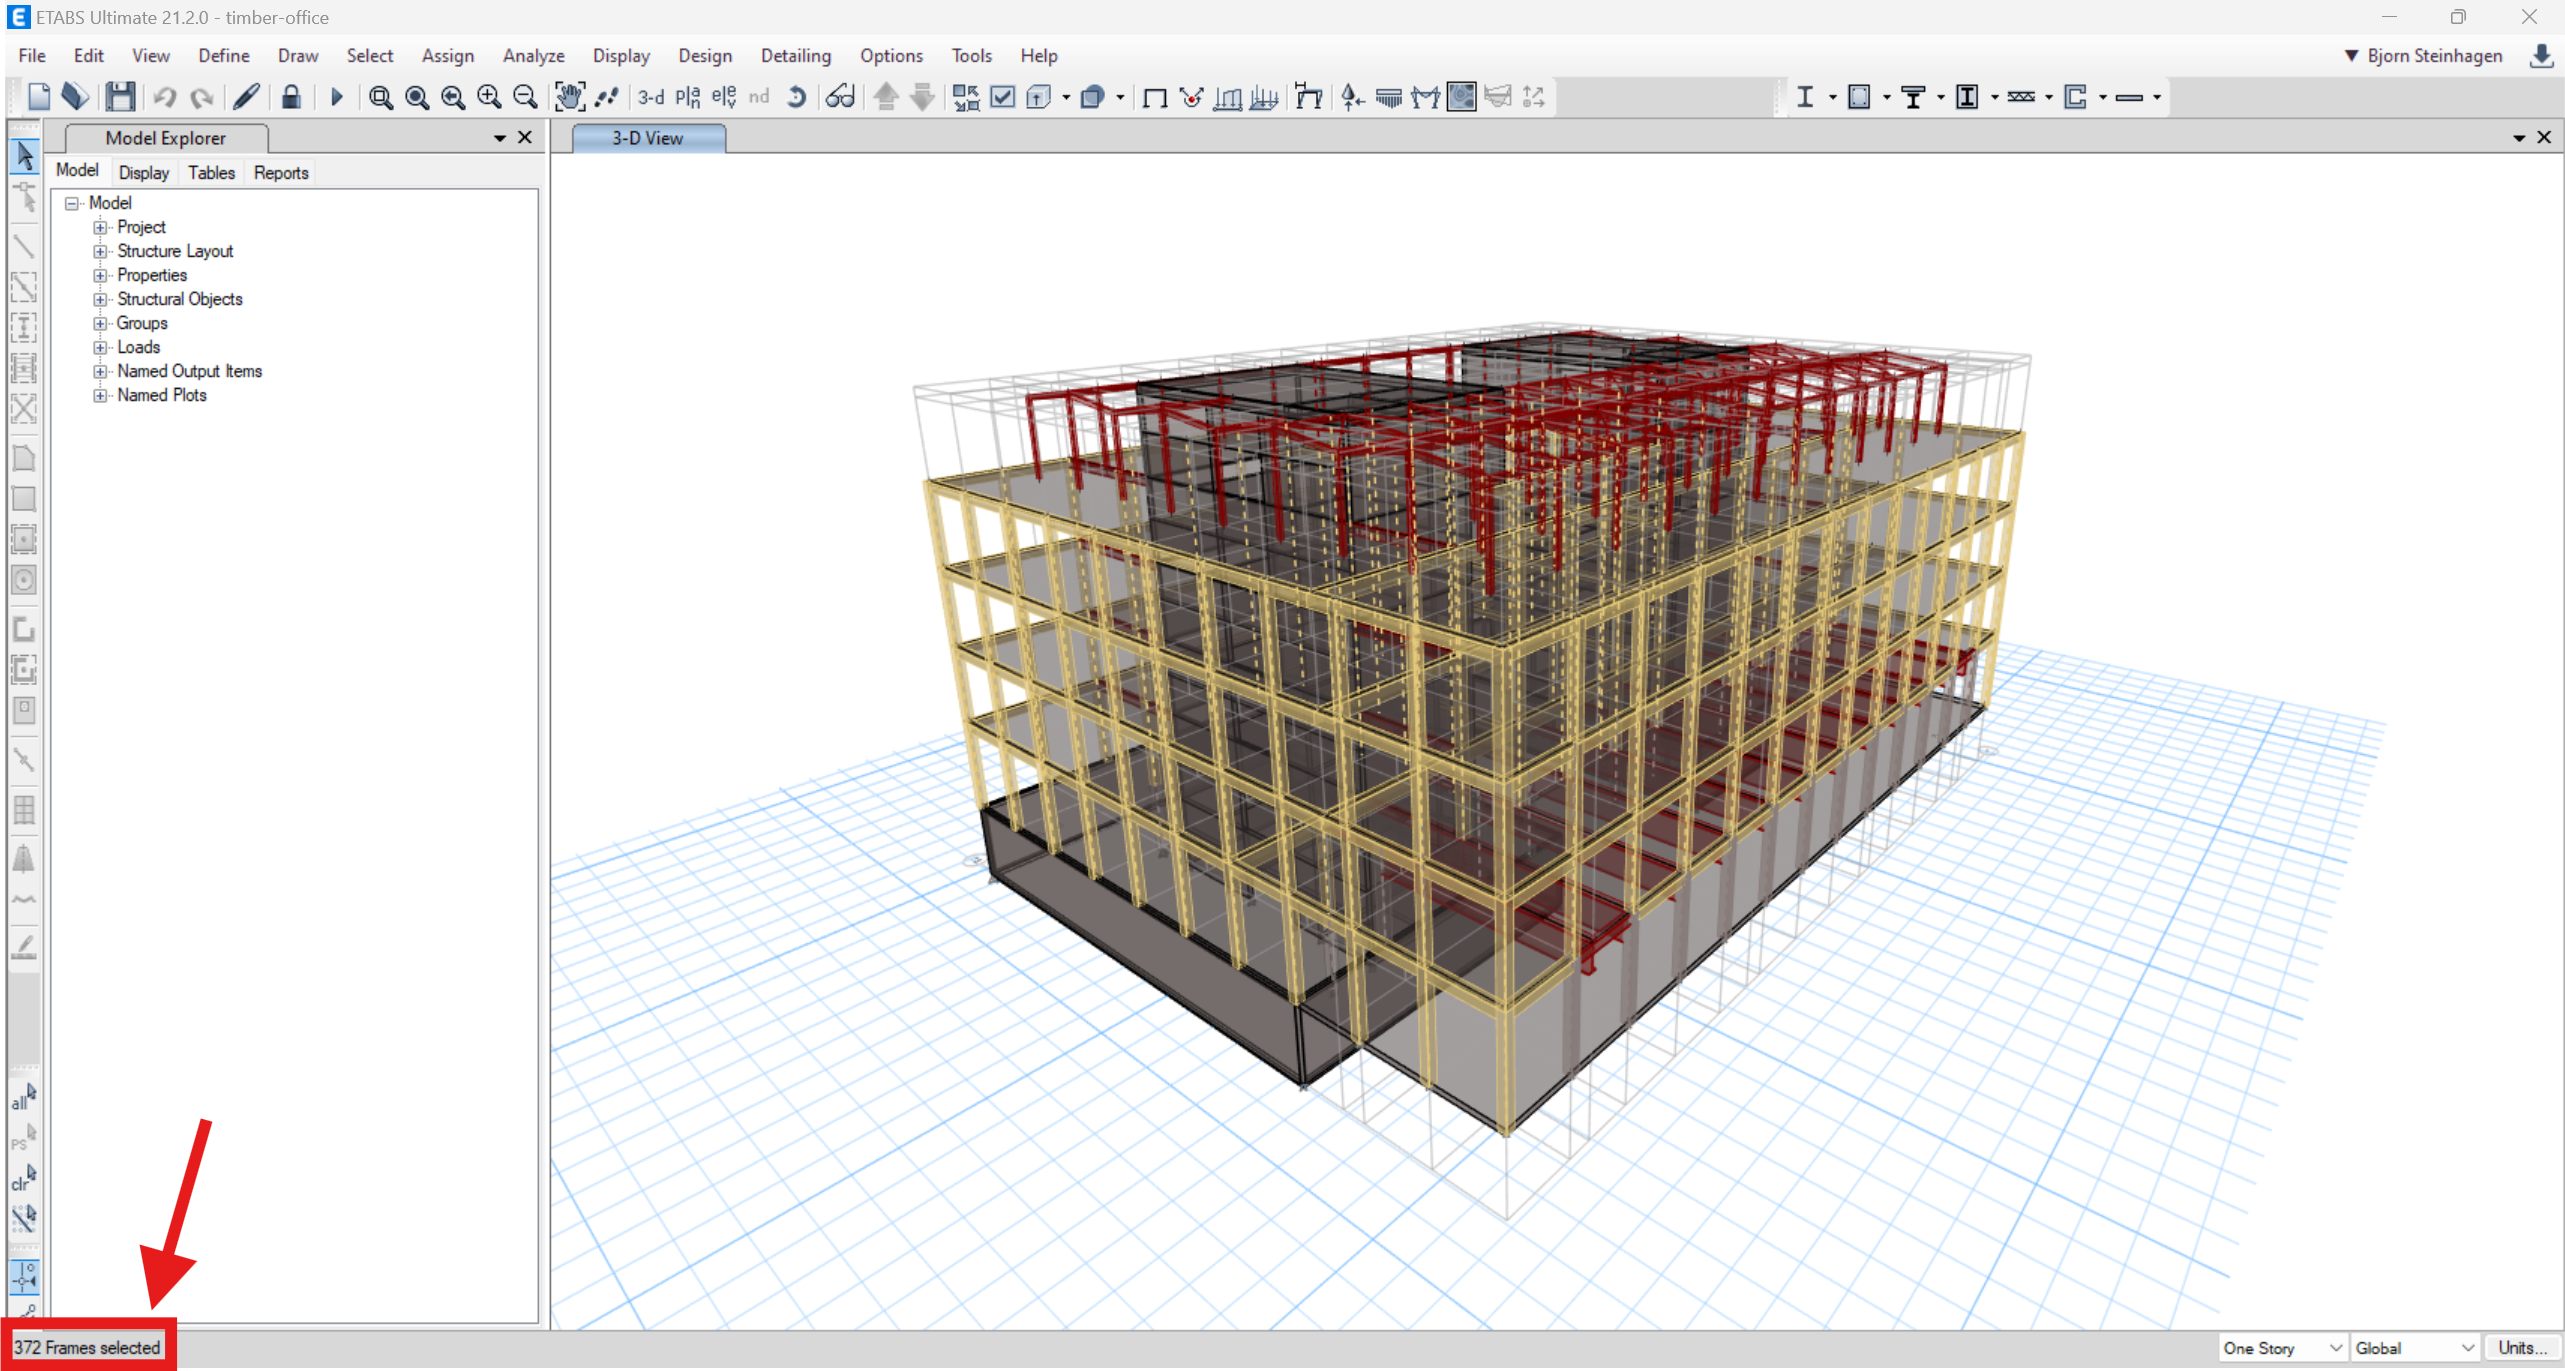

#### 🧼 Step 04 - Clean Analysis Results
The aim of the game, is to create a pandas dataframe for some quick filtering, sorting, grouping etc. But, how does the `AnalysisResults` look like in its current state?

In [ ]:
# We can just look at the first column in the colums list
vars(columns[0].AnalysisResults)

In [ ]:
# We want to have the resultsByLoadCombination
vars(columns[0].AnalysisResults.resultsByLoadCombination[0])

In [ ]:
# From the three internal foce cases, we want the maximum and minimum forceX
vars(columns[0].AnalysisResults.resultsByLoadCombination[0].results1D[0])

In [ ]:
# We want to know from which load combination they come from. i.e. the name
vars(columns[0].AnalysisResults.resultsByLoadCombination[0].resultCase)

We have a good idea of where everything is, now we can think about our datarame design

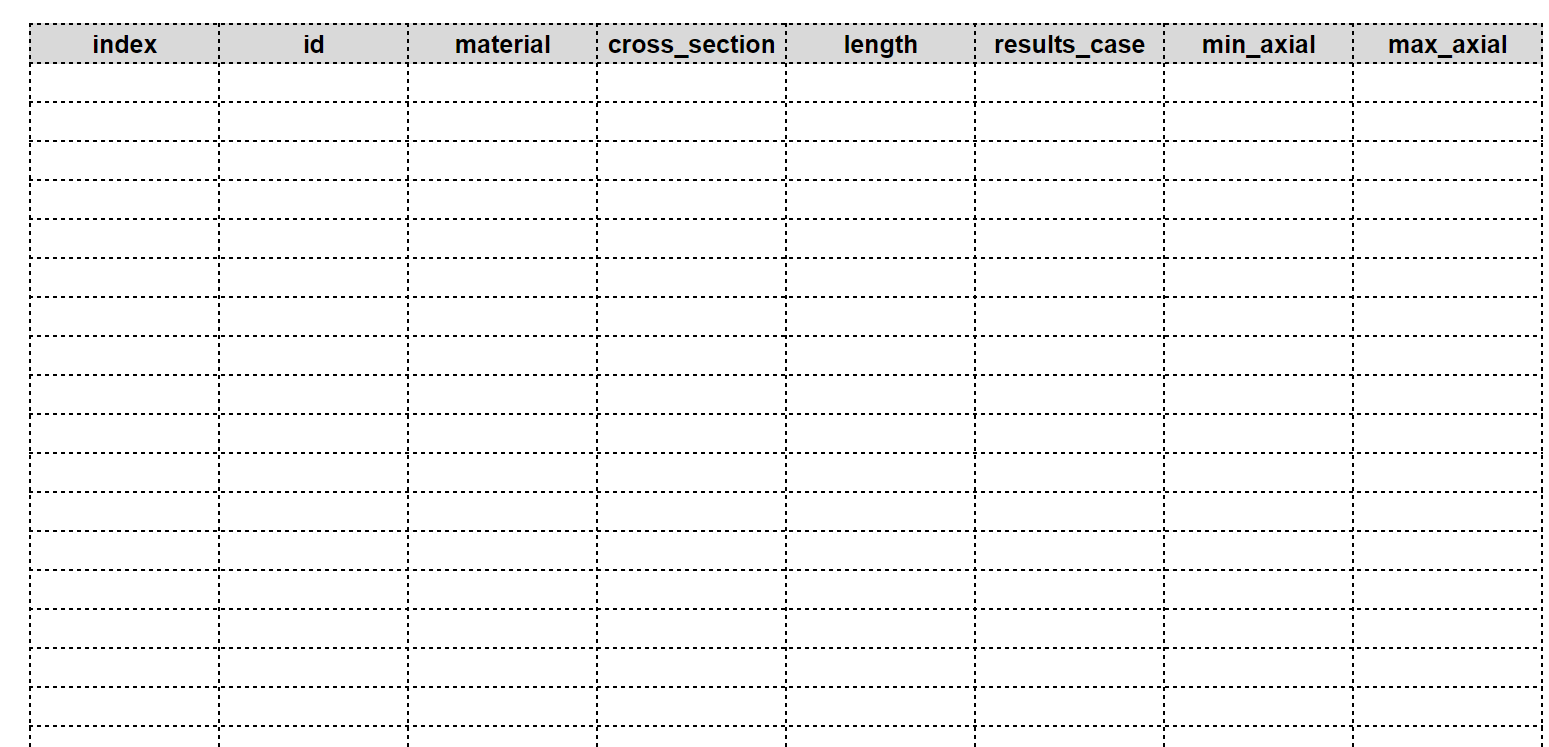

In [ ]:
import pandas as pd
from IPython.display import display

# Initialize a list to store data
data = []

# Loop over each column (element) and extract properties
for column in columns:
    # Extract the element-level properties
    element_id = column.id
    material = column.property.material.materialType.name
    cross_section = column.property.profile.name
    length = column.baseLine.length
    
    # Loop over each result case for the element
    for result in column.AnalysisResults.resultsByLoadCombination:
        results_case = result.resultCase.name
        
        # Extract axial forces for this result case
        axial_forces = [internal_forces.forceX for internal_forces in result.results1D]
        
        # Calculate min and max axial force for this case
        min_axial = min(axial_forces)
        max_axial = max(axial_forces)
        
        # Append a dictionary to the data list for this result case
        data.append({
            "index": len(data),
            "id": element_id,
            "material": material,
            "cross_section": cross_section,
            "length": length,
            "results_case": results_case,
            "min_axial": min_axial,
            "max_axial": max_axial
        })

# Create DataFrame from the data list
df = pd.DataFrame(data, columns=["index", "id", "material", "cross_section", "length", "results_case", "min_axial", "max_axial"])

display(df)


#### 🤔 Step 05 - Insights and Results
From the dataframe, we can rapidly extract a lot of information, statistics etc.

In [ ]:
# Group by 'cross_section' and find the minimum 'min_axial' for each group
min_axial_per_cross_section = df.groupby("cross_section")["min_axial"].min().reset_index()

# Convert 'min_axial' from N to kN
min_axial_per_cross_section["min_axial"] = min_axial_per_cross_section["min_axial"] / 1000

# Display the result
print(min_axial_per_cross_section)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a modern seaborn style
sns.set_theme(style="whitegrid")

# Aggregate min and max axial forces per cross_section
summary_df = df.groupby("cross_section")[["min_axial", "max_axial"]].agg(["min", "max"]).reset_index()
summary_df.columns = ["cross_section", "min_min_axial", "max_min_axial", "min_max_axial", "max_max_axial"]

# Plot min and max axial forces by cross-section
plt.figure(figsize=(12, 6))
sns.barplot(data=summary_df, x="cross_section", y="min_min_axial", color="skyblue", label="Min Axial Force", alpha=0.8)
sns.barplot(data=summary_df, x="cross_section", y="max_min_axial", color="orange", label="Max Axial Force", alpha=0.8)
plt.title("Minimum and Maximum Axial Forces by Cross-Section", fontsize=16)
plt.ylabel("Axial Force (N)", fontsize=12)
plt.xlabel("Cross Section", fontsize=12)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(14, 8))
for cross_section, subset in df.groupby("cross_section"):
    sns.lineplot(data=subset, x="results_case", y="min_axial", marker="o", label=cross_section)

plt.title("Axial Force Trends by Cross-Section and Load Case", fontsize=16)
plt.ylabel("Min Axial Force (N)", fontsize=12)
plt.xlabel("Load Case", fontsize=12)
plt.legend(title="Cross Section", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()